#Блок установки пакетов
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install scikit-learn
!pip install requests
!pip install geopy

In [5]:
import pandas as pd
import numpy as np
import re
import requests
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import seaborn as sns
from bs4 import BeautifulSoup
import time

In [6]:
hotels = pd.read_csv('./data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [7]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [8]:
#Удаляем дубликаты 
hotels = hotels.drop_duplicates()

<AxesSubplot: ylabel='reviewer_score'>

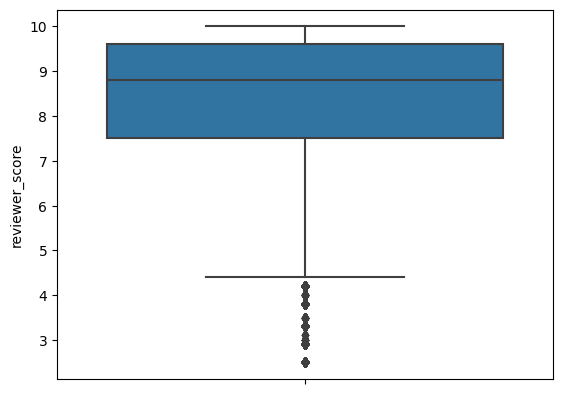

In [9]:
#Смотрим выбросы
sns.boxplot(y=hotels['reviewer_score'])


Наличие выбросов (эксперименты показали, что это действительно выбросы, т.к. очистка дала положительный результат на метрику)

In [10]:
# Функция z-отклонений

def outliers_z_score(data, feature, left_mod=2, right_mod=3, log_scale=False):
    
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]

    mu = x.mean()

    sigma = x.std()

    lower_bound = mu - left_mod * sigma

    upper_bound = mu + right_mod * sigma

    outliers = data[(x < lower_bound) | (x > upper_bound)]

    cleaned = data[(x > lower_bound) & (x < upper_bound)]

    print(f'Количество выбросов по z-методу: {outliers.shape[0]}')
    print(f'Результирующее количество строк в очищенном фрейме: {cleaned.shape[0]}')

    return outliers, cleaned

In [11]:
outliers, data = outliers_z_score(data=hotels, feature='reviewer_score', log_scale=True, left_mod=3, right_mod=3)

Количество выбросов по z-методу: 7997
Результирующее количество строк в очищенном фрейме: 378499


In [12]:
outliers.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000,7949.000000,7949.000000
mean,575.948356,7.903414,50.101163,3155.999625,7.777542,5.458797,3.265525,49.657551,2.514527
std,630.343734,0.621663,63.233038,2703.147270,17.888283,8.896771,0.498053,3.252028,4.194720
min,1.000000,5.200000,0.000000,49.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,185.000000,7.500000,11.000000,1295.000000,0.000000,1.000000,2.900000,48.849485,-0.168358
50%,369.000000,8.000000,29.000000,2383.000000,3.000000,2.000000,3.300000,51.501910,-0.023221
75%,709.000000,8.400000,63.000000,3980.000000,8.000000,6.000000,3.800000,51.516689,2.359778
max,2682.000000,9.500000,402.000000,16670.000000,386.000000,211.000000,3.800000,52.400181,16.421974


<AxesSubplot: ylabel='reviewer_score'>

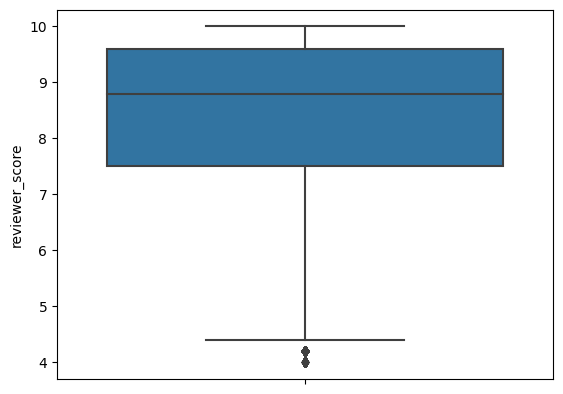

In [13]:
# Посмотрим на остаточные выбросы
sns.boxplot(y=data['reviewer_score'])

In [14]:
# Дочистим
outliers, data = outliers_z_score(data=data, feature='reviewer_score', log_scale=True, left_mod=3, right_mod=3)

Количество выбросов по z-методу: 3994
Результирующее количество строк в очищенном фрейме: 374505


<AxesSubplot: ylabel='reviewer_score'>

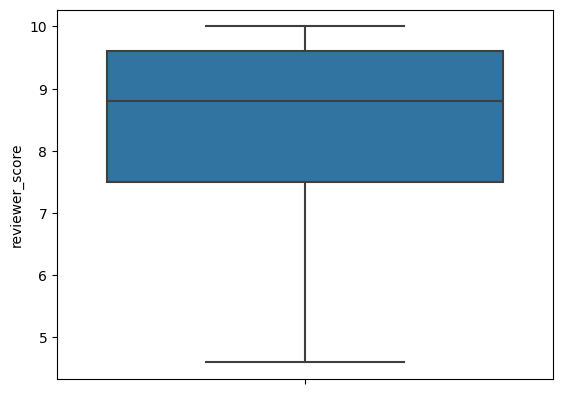

In [15]:
sns.boxplot(y=data['reviewer_score'])

Дочистили

<AxesSubplot: ylabel='review_total_negative_word_counts'>

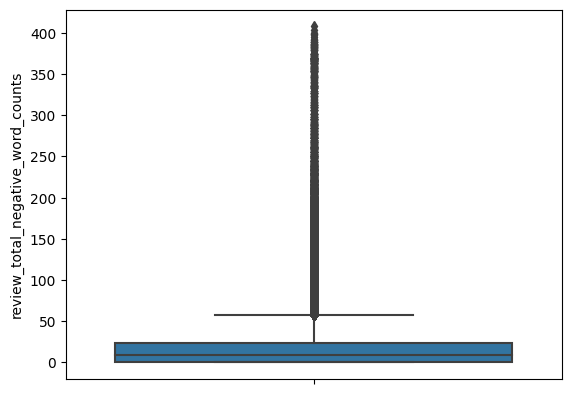

In [18]:
sns.boxplot(y=data['review_total_negative_word_counts'])

In [192]:
#Проработать признак популярности отеля по количеству упоминаний

In [177]:
#Проработать признак существенности негатива/позитива на основании количества слов

---

Преобразование тегов (в датасете теги представлены единой строкой)

In [193]:
# Пркобразование тегов к списку
def tag_reconstr(data):
    temp_list = []
    for i in data.split("'"):
        temp_list.append(i.strip())

    temp_list.remove('[')
    temp_list.remove(']')

    for i in temp_list:
        if i == ',':
            temp_list.remove(i)
    return temp_list


tags_series = data['tags'].apply(tag_reconstr)
data['tags'] = data['tags'].apply(tag_reconstr)

#Формируем базу для one_hot, параллельно выдергиваем фит прожитых ночей
all_tags = tags_series.explode()
stayed_night_mask = all_tags.str.contains('Stayed', regex=False)
stayed_night = all_tags[stayed_night_mask]
stayed_night.str.split(' ')

def night_at_hotel(data):
    temp_var = 0
    for i in data.split(' '):
        try:
            temp_var = int(i)
        except ValueError:
            pass
    return temp_var

nights = stayed_night.apply(night_at_hotel)
nights = nights.rename('nights')
data = pd.concat([data, nights], axis=1)
data['nights'] = data['nights'].fillna(data['nights'].mode()[0])

#Вытаскиваем топ 50 тегов и разворачиваем на их основе one_hot
top_tags = all_tags.value_counts()[:51]
mask = top_tags.index.str.contains('Stayed', regex=False)
one_hot_columns = list(top_tags[~mask].index)

for element in one_hot_columns:
    data[element] = data['tags'].apply(lambda x: 1 if element in x else 0)

---

Получим рейтинг отеля с гугла (проверим будет ли польза от внешнего рейтинга отеля, за основу берется рейтинг приходящий с tripadvisor)

In [3]:
# Playing with bs and requests
url_base = f'https://www.google.com/search?q='  # база запроса к гуглу
# Пришлось, но особо от блока ip не помогло
proxies = {
    'http': 'http://10.10.1.10:3128'
}
headers={
    'User-Agent': 'Mozilla/5.0'
}
lost_dict = dict()

In [ ]:
#Для чека вывода
x = requests.get('https://www.google.com/search?q=Grand+Royale+London+Hyde+Park',headers={'User-Agent': 'Mozilla/5.0'})
soup = BeautifulSoup(x.text)
soup

In [148]:
# Эмпирическим путем выведено, что гугл начинает блочить при количестве запросов больше 600, т.ч не жадничаем
# Формируем первый словарь для последующего слияния
hotels_dict_1 = dict()
hotels_array_1 = [hotels['hotel_name'].unique()][0][0:501]
for i in hotels_array_1:
    hotels_dict_1[i] = f"{url_base}{i.replace(' ','+')}"


In [149]:
# Наполняем словарь полученой информацией
star_dict_1 = dict()
for key, link in hotels_dict_1.items():
    try:
        url = link
        # попытка с хэдлеслом закончилась блоком по ip
        response = requests.get(url, headers=headers, proxies=proxies)
        soup = BeautifulSoup(response.text)
        star = soup.findAll('span', class_='oqSTJd')[0].text.replace(',', '.')
        star_dict_1[key] = star
        # попробую с этим таймером, без слипа гугл заблочил на день, есть вероятность что парсить будет в районе 30 минут
        time.sleep(0.3)
    except IndexError:  # есть один отель который гугл воспринимает как запрос на персоналию + индексэр выпадает когда блокают или когда у отеля нет рейта
        print(f'{key}: {link}')
        lost_dict[key]= link
        pass
    except ConnectionError:
        print(f'{key}: {link}')
        lost_dict[key]= link
        pass

Henry VIII: https://www.google.com/search?q=Henry+VIII
Bassano: https://www.google.com/search?q=Bassano


In [180]:
star_df_1 = pd.DataFrame({'hotel': star_dict_1.keys(), 'star_rate':star_dict_1.values()})

In [154]:
# Сохраним для дальнейшего слияния и легкого доступа без парсинга каждый раз
with pd.ExcelWriter(
            "./data/star_rating_1.xlsx") as writer:
        star_df_1.to_excel(writer, sheet_name='stars')

In [239]:
# Формируем второй словарь для последующего слияния
hotels_dict_2 = dict()
hotels_array_2 = [hotels['hotel_name'].unique()][0][501:1001]
for i in hotels_array_2:
    hotels_dict_2[i] = f"{url_base}{i.replace(' ','+')}"

In [240]:
# Наполняем словарь полученой информацией
star_dict_2 = dict()
for key, link in hotels_dict_2.items():
    try:
        url = link
        # попытка с хэдлеслом закончилась блоком по ip
        response = requests.get(url, headers=headers, proxies=proxies)
        soup = BeautifulSoup(response.text)
        star = soup.findAll('span', class_='oqSTJd')[0].text.replace(',', '.')
        star_dict_2[key] = star
        # попробую с этим таймером, без слипа гугл заблочил на день, есть вероятность что парсить будет в районе 30 минут
        time.sleep(0.3)
    except IndexError:  # есть один отель который гугл воспринимает как запрос на персоналию + индексэр выпадает когда блокают или когда у отеля нет рейта
        print(f'{key}: {link}')
        lost_dict[key]= link
        pass
    except ConnectionError:
        print(f'{key}: {link}')
        lost_dict[key]= link
        pass

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
star_df_2 = pd.DataFrame({'hotel': star_dict_2.keys(), 'star_rate':star_dict_2.values()})

In [158]:
with pd.ExcelWriter(
            "./data/star_rating_2.xlsx") as writer:
        star_df_2.to_excel(writer, sheet_name='stars')

In [175]:
# Формируем третий словарь для последующего слияния
hotels_dict_3 = dict()
hotels_array_3 = [hotels['hotel_name'].unique()][0][501:1493]
for i in hotels_array_3:
    hotels_dict_3[i] = f"{url_base}{i.replace(' ','+')}"

In [ ]:
# Наполняем словарь полученой информацией
star_dict_3 = dict()
for key, link in hotels_dict_3.items():
    try:
        url = link
        # попытка с хэдлеслом закончилась блоком по ip
        response = requests.get(url, headers=headers, proxies=proxies)
        soup = BeautifulSoup(response.text)
        star = soup.findAll('span', class_='oqSTJd')[0].text.replace(',', '.')
        star_dict_3[key] = star
        # попробую с этим таймером, без слипа гугл заблочил на день, есть вероятность что парсить будет в районе 30 минут
        time.sleep(0.3)
    except IndexError:  # есть один отель который гугл воспринимает как запрос на персоналию + индексэр выпадает когда блокают или когда у отеля нет рейта
        print(f'{key}: {link}')
        lost_dict[key]= link
        pass
    except ConnectionError:
        print(f'{key}: {link}')
        lost_dict[key]= link
        pass

In [179]:
star_df_3 = pd.DataFrame({'hotel': star_dict_3.keys(), 'star_rate':star_dict_3.values()})

In [ ]:
with pd.ExcelWriter(
            "./data/star_rating_3.xlsx") as writer:
        star_df_3.to_excel(writer, sheet_name='stars')

Дообработаем excel файлы руками (количество изменений располагает к рациональному подходу, и имеют в масштабах татасета малый вес), можно было заменить значения модальными

In [ ]:
lost_dict_man = {
    'Henry VIII': 'https://www.google.com/search?q=Henry+VIII',
    'Bassano': 'https://www.google.com/search?q=Bassano',
    'Elys es R gencia': 'https://www.google.com/search?q=Elys+es+R+gencia',
    'Amp re': 'https://www.google.com/search?q=Amp+re',
    'Thistle Euston': 'https://www.google.com/search?q=Thistle+Euston',
    'Villa d Estr es': 'https://www.google.com/search?q=Villa+d+Estr+es',
    'K K H tel Cayr Saint Germain des Pr s': 'https://www.google.com/search?q=K+K+H+tel+Cayr+Saint+Germain+des+Pr+s',
    'Vice Versa': 'https://www.google.com/search?q=Vice+Versa',
    'Arioso': 'https://www.google.com/search?q=Arioso',
}

In [107]:
'''star_df = pd.DataFrame({'hotel': star_dict.keys(), 'star_rate':star_dict.values()})
with pd.ExcelWriter(
            "./data/star_rating.xlsx") as writer:
        star_df.to_excel(writer, sheet_name='curr')'''

---

Кодируем отели

In [207]:
#Кодируем названия отелей
data['hotel_name'] = data['hotel_name'].astype('category')
data['hotel_name'] = data['hotel_name'].cat.codes

Код отеля по коду его страны

In [208]:
# Достаем код страны
response = requests.get('https://countrycode.org/')
country_code = pd.read_html(response.text)
country_code = country_code[0]
country_code = country_code[['COUNTRY', 'COUNTRY CODE']]

# Создаем функцию для формирования кодовой строки исходя из принципа территориальной близости принадлежности для кодов формата Х-ХХХ
def get_code(data):
    data = data.split('-')
    return int(data[0])


country_code['COUNTRY CODE'] = country_code['COUNTRY CODE'].apply(get_code)

# Формируем новый закодированный (в последствие) признак местоположения отеля
data['hotel_country'] = data['hotel_address'].str.split(' ')
data['hotel_country'] = data['hotel_country'].apply(lambda x: x[-2::])
data['hotel_country'] = data['hotel_country'].apply(
    lambda x: x[0]+' '+x[1] if x[0] == 'United' else x[1])

data = data.merge(
    country_code, how='left',
    left_on='hotel_country', right_on='COUNTRY'
)
data = data.rename(columns={'COUNTRY CODE': 'hotel_country_code'})


---

Код ревьюера по его национальной принадлежности

In [209]:
# Стрипуем национальность для будущего присвоения кода страны
data['reviewer_nationality'] = data['reviewer_nationality'].str.strip()
# Переименуем пару стран
data['reviewer_nationality'] = data['reviewer_nationality'].str.replace(
    'United States of America', 'United States')

# Формируем новый фрейм с кодом страны ревьюера
data = data.merge(
    country_code, how='left',
    left_on='reviewer_nationality', right_on='COUNTRY'
)

data = data.rename(
    columns={'COUNTRY CODE': 'nationality_code', 'COUNTRY': 'reviewer_country'})

data['nationality_code'] = data['nationality_code'].fillna(
    data['nationality_code'].mode()[0])


Являетлся ли ревьюер жителем страны в которой находится отель

In [210]:
data['is_citizen'] = data['nationality_code'] == data['hotel_country_code']
data['is_citizen'] = data['is_citizen'].apply(lambda x: 1 if x == True else 0)

---

Вытаскиваем город для дальнейших манипуляций с растояниями до различных объектов

In [211]:
#Создаем признак города
data['city'] = data['hotel_address'].str.split(' ')
data['city'] = data['city'].apply(lambda x: x[-5] if x[-1] == 'Kingdom' else x[-2])

In [212]:
#Cоздаем список городов в сете
city_list = list(data['city'].unique())
city_list

['London', 'Paris', 'Amsterdam', 'Milan', 'Vienna', 'Barcelona']

In [213]:
# Условные центры городов выбранные на основание исторических достопримечательностей. 
# В данном случае рассматриваются центры притяжения для отдыха, но не бизнес поездок, 
# т.к. предыдущие изыскания показали превалирующую долю в датасете и признак бизнес поездок был дропнут
# в виду наличия мультиколлинеарности и меньшей доли. 

cities_coordinates = {
    'London': (51.50458, -0.1332), 'Paris': (48.85637, 2.33475),
    'Amsterdam': (52.374787, 4.896339), 'Milan': (45.470098, 9.179906),
    'Vienna': (48.207904, 16.368116), 'Barcelona': (41.399367, 2.169938)
}


Немного прервемся с расстоянием

Заполняем пропуски в широте и долготе используя адреса отелей

In [214]:
#Создаем пустые списки, в них будем нарезать куски адресов, точность будет не абсолюьная, но приемлимая
temp_list = []
list_of_nan = []
address_list = []

#Создаем список уникальных адресов отелей с пропусками
empty_loc = data[data['lat'].isnull()]
empty_hot_list = list(empty_loc['hotel_address'].unique())

#Планомерно заполняем наши списки, впоследующем address_list используем для получения кортежей lat/lng
for i in empty_hot_list:
    temp_var = i.split(' ')[-1:-4:-1]
    temp_list.append(temp_var)
    
for i in temp_list:
    list_of_nan.append(i[::-1])

for i in list_of_nan:
    address_list.append(' '.join(i))
    

#Пробегаем циклом по адресам и создаем список кортежей ключ- часть адреса, значение lat/lng
location_tuple_dict = dict()
lat_dict = dict()
lng_dict = dict()
geolocator = Nominatim(user_agent="my_request")
for loc in address_list:
    location = geolocator.geocode(loc)
    location_tuple_dict[loc]=(location.latitude, location.longitude)
    lat_dict[loc] = location.latitude
    lng_dict[loc] = location.longitude

# Востанавливаем словарь с полным названием, после всех манипуляций у нас есть словарь с ключами
# в виде полного адреса и значениями в виде кортежа координат
new_lat_dict = dict()
for i in lat_dict:
    for j in empty_hot_list:
        if i in j:
            new_lat_dict[j] = lat_dict[i]
            
new_lng_dict = dict()
for i in lng_dict:
    for j in empty_hot_list:
        if i in j:
            new_lng_dict[j] = lng_dict[i]

In [215]:
#Заполним пустоты в широте
data['lat'] = data['lat'].fillna(data['hotel_address'].apply(lambda x: new_lat_dict.get(x)))

In [216]:
#И долготе
data['lng'] = data['lng'].fillna(data['hotel_address'].apply(lambda x: new_lng_dict.get(x)))

In [217]:
#Создаем новый фит координат отеля
data['coordinates'] = tuple(zip(data['lat'], data['lng']))


Вернемся к расстояниям

In [218]:
# Функция для нахождения расстояния
data['distance_center'] = data['coordinates'].apply(
    lambda x: geodesic(x, cities_coordinates[data['city'][0]]).km)


Вытаскиваем день недели и отдельно месяц

In [219]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['month'] = data['review_date'].dt.month
data['day_of_week'] = data['review_date'].dt.day_of_week

---

Количество дней с момента отзыва как int

In [222]:
# Достаем количество дней c момента публикации ревью
def days_num(string_):
    regexp = re.findall(r'\d{0,5}', string_)
    return regexp[0]


data['days_since_review'] = data['days_since_review'].apply(days_num)
data['days_since_review'] = data['days_since_review'].astype('int')


TypeError: expected string or bytes-like object, got 'int'

<AxesSubplot: ylabel='days_since_review'>

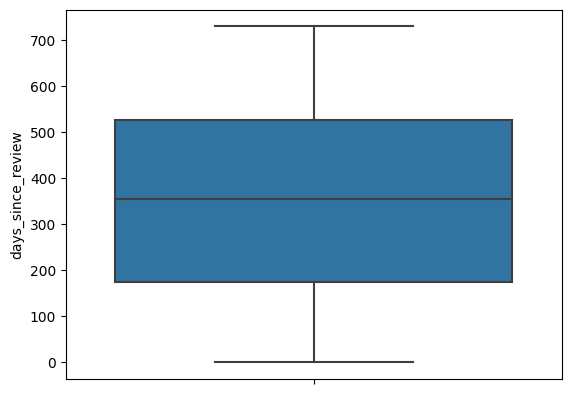

In [223]:
#Проверим выбросы в разрезе количества дней пройденных с момента отзыва
sns.boxplot(y=data['days_since_review'])

<AxesSubplot: xlabel='days_since_review', ylabel='Count'>

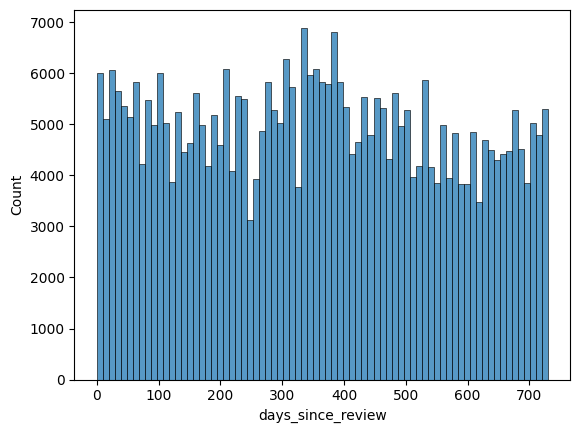

In [224]:
sns.histplot(data['days_since_review'])

Нет четкого пониманияя касательно распределения

In [225]:
#Создаем классификацию "свежести" отзыва на основании перцентилям
data['days_since_review'].describe()

count    374505.000000
mean        354.706266
std         208.770585
min           0.000000
25%         175.000000
50%         354.000000
75%         527.000000
max         730.000000
Name: days_since_review, dtype: float64

In [226]:
#Функция для категоризации
def freshness(data):
    x = 0
    if data <= 175:
        x = 1
    elif 175 < data <= 354:
        x = 2
    elif 354 < data <= 527:
        x = 3
    else:
        x = 4
    return x

In [227]:
data['days_since_review'] = data['days_since_review'].apply(freshness)

Проверяем на мультиколлинеарность

/var/folders/1_/hgb3xg852md0hqqs3ybwbsp40000gn/T/ipykernel_38789/1607366581.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  whole_corr = data.corr()[(data.corr() > 0.7) | (data.corr() < -0.7)]


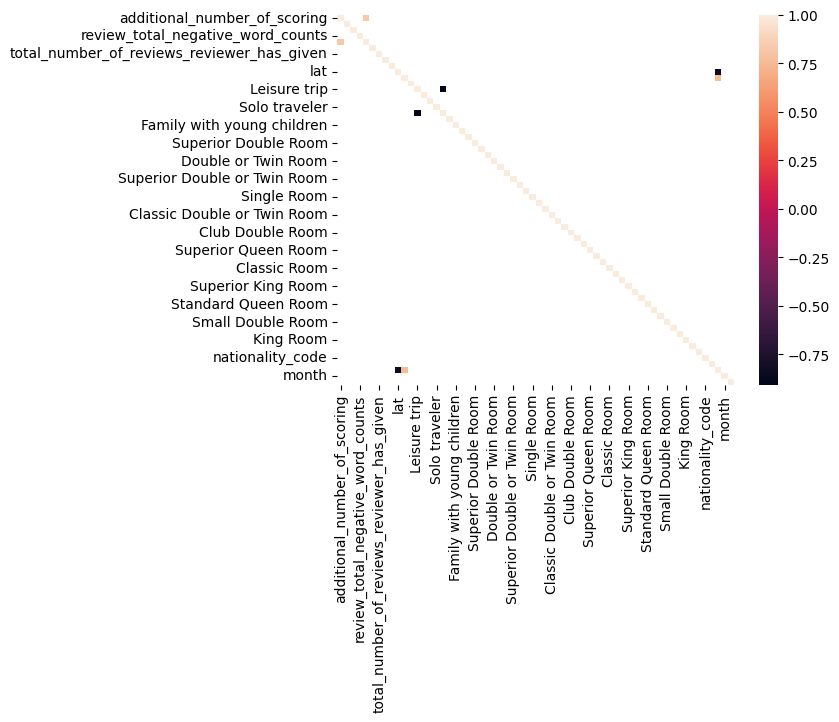

In [228]:
whole_corr = data.corr()[(data.corr() > 0.7) | (data.corr() < -0.7)]
sns.heatmap(whole_corr);

In [229]:
#Список фитов с мультиколлинеарностью
direct_corr = whole_corr.count(axis=0)
corr_columns = pd.DataFrame({'Name':direct_corr.index, 'CNT':direct_corr.values})
corr_columns.query("CNT > 1")

,Name,CNT
0,additional_number_of_scoring,2
4,total_number_of_reviews,2
9,lat,2
10,lng,2
12,Leisure trip,2
16,Business trip,2
59,distance_center,3


In [230]:
data.drop(['additional_number_of_scoring', 'Business trip', 'lat', 'lng'], axis=1, inplace=True)
#Дропаем столбец даты что бы модель могла работать
data.drop(['review_date'], axis=1, inplace=True)

---

In [231]:
#Дропаем строковые фиты
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [232]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 

In [233]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [234]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [235]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)


In [236]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.11080332763487251


MAPE: 0.11069189682679137